## So what did we do?

At a practical level, we have *forked* code from the Pace of Change [git repository](https://github.com/tedunderwood/paceofchange) and created a new *branch* containing the Jupyter Notebook you are reading now. Transforming Underwood and Seller's code from a set of python script into the notebook involved a series of transformation to their code. The provenance of this effort has been preserved because we did all of our work in the the fork of their version repository, visible via the `git history` command.

Underwood and Sellers' have crafted their code in such a way that it is possible to replicate their results by running a single command. One of our first tasks was to trace the code and follow the path of execution from the initial command to the output data files. In reading through the code (spanning across multiple python scripts) we could piece together a rough idea of how Underwood and Sellers' performed their data preparation, normalization, and analysis. While we could read their python source code, plain text files leave much to be desired with trying to critically engage code. This is why we made the effort to translate their scripts into a Jupyter Notebook.

This process of translation involved copying bits of code from various `.py` files into a single executable notebook.  Not all of the code in the git repository was copied into the notebook for three main reasons. First, not all of the code included in the files was actually needed to replicate the analysis process. The repository includes extra code, one could call it "cruft", from Underwood and Seller's exploratory analysis or earlier iterations of the analytical process. For example, the file `SonicScrewdiver.py` is never called upon although, based upon the name, we might hypothesize it is an important catch-all module for a variety of different tasks. Other sections of the code are commented out (such as `binormal_select` discussed below) and never executed. As part of the defactoring process, we opted to not include unused functions or code blocks. The second reason for not include could was not all of the possible execution paths are represented in this Notebook. There six allowable options for slicing the data in `replicate.py`, the entry-point for re-running the analysis. In this notebook we follow the default, "full", which models the entire dataset. The third reason we did not include some code was because of the use of external libraries. While most of the scripts are bespoke code for working with unique data, some sections of the code lik the logistic regression are part of a third-party library, `scikit-learn`, that for a multitude of reasons (including practicality) we decided to "step over" and not defactor. When trying to follow the path of execution for any program one needs to recognize it is "[turtles all the way down](https://en.wikipedia.org/wiki/Turtles_all_the_way_down)." To make our task possible, we have to make a decision about how far down the path of execution the defactoring process will go. We make a decision to focus only on the code written by Underwood and Sellers and leave an analysis of subsequent third-party libraries to a later, and more ambitious, defactoring effort.

![Defactoring code from python files to the notebook](notebook_resources/defactoring.png)

Underwood and Seller's code is stored within four files, `replicate.py`, `parallel_crossvalidate.py`, `metafilter.py`, and `modlingprocess.py`. Through the process of *defactoring* we have copied|move|transferred|imported code from text files to a Jupyter Notebook. This process has transformed the flow of the code, but not the outputs. 

In order for the code to execute seamlessly within the notebook, we had to make minor changes and tweaks to the code. These changes fall into 5 categories:

* *defactoring functions* - This is the most significant of the changes. When we defactor a function we take the function's code and move it to the global namespace. This has the effect of elimiating the function and just making it part of the main execution path. 
* *defactoring function calls* - When a function has been defactored, it can no longer be called since there is no explicit definitional code.
* *defactoring definitions* - Not all functions can be fully defactored. Functions that are called more than once or those that are short have been kept as re-usable functions. Defactoring Definition cells define the functions above the code cells that use them (preventing errors).
* *defactoring namespace* - Because we have defactored some of the functions and their function calls some of the variables in the namespace need to be mapped to eachother. This happens we the return value of a defactored function needs to be stored in a differently named variable.
* *defactoring inspections* - When we want to inspect the state of the process, we insert an inspection cell that prints the values of the variables of interest.
* *defactoring import* - Because the code is reliant upon external and third party functions, we need to import that code into the global namespace. This cell contains all of those imports.


One of the advantages to defactoring a function is it affords us the ability to insert critical commentary (in the form of markdown cells) into the code constituting the function itself. An unfortunate side-effect is that this makes keeping track of one's place in the code a bit difficult. 

## Diving into the Code



The code expressed below has nine steps:
* [Setting Parameters](#Setting-Parameters) - Specifies parameters for the loading, cleaning, and labeling of data as well as sets conditions for the logistic regression.
* [Preparing Metadata](#Preparing-MetaData) - Generates a list of *.tsv files from the `poems/` directory. 
    * [Cleaning Metadata](#Cleaning-Metadata) - Loads the metadata file, `poemetadata.csv` and performs some cleaning of the metadata to make labeling easier.
    * [Sorting Data](#Sorting-Data) - Sort the volumes into two bins, reviewed and not reviewed using the cleaned metadata.
* [Transforming Words into Features](#Transforming-Words-into-Features) - Identifies the 3,200 most common words in the corpus. Those most common words will be the features for the regression.
    * [Filtering Authors](#Filtering-Authors) - Removes poems by authors who have been reviewed.
    * [Filtering Words](#Filtering-Words) - Remove any words from the poem data that are not in the most-common feature list.
* [Training Predictive Models](#Training-Predictive-Models) - Run a separate logistic regression for each volume, using a single volume as held-out data and measure each model's predictive power.
* [Modeling Coefficients](#Modeling-Coefficients) - Run a single logistic regression over all the data to inspect the salient coefficients.
* [Plotting Results](#Plotting-Results) - Generate a plot showing the accuracy of the predictive models.



#### How to read this notebook

This notebook is divided into a series of cells, *code cells* and *text cells*. Code cells contain python code mostly written by Underwood and Selles, but with a few modificaitons by us. We have broken up their code and inserted text cells, written by us, which discuss and explain what is happening in the code cells. In most cases the expository text is *below* the code cell.

Let's get started!

In [1]:
### DEFACTORING IMPORT
import os
import csv 
import random 
from collections import Counter 

import numpy as np 
import pandas as pd 

from multiprocessing import Pool 
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.linear_model import LogisticRegression

*Note to the reader. If you see a red warning box don't fret, this is a by-product of our effort to Dockerize this analysis. Hopefully this will someday go away.*

We begin this journey into code by importing a series of python libraries into working memory. Some of these libraries are part of the standard library–`os`, `csv`, `random,` and `multiprocesing`–but other libraries are third-party–`numpy`, `pandas`, and most importantly `sklearn`. These import statements tell us what libraries the authors will be relying upon for their analysis. The last line imports the `LogisticRegression` implementation from the [scikit-learn library](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). The authors are [standing on the shoulders of giants](https://en.wikipedia.org/wiki/Standing_on_the_shoulders_of_giants) to use this popular python implementation of logistic regression to conduct their analysis. Another interesting import statement is the `Pool` function from the python `multiprocessing` library. Normally python operates as a [single-threaded process](https://en.wikipedia.org/wiki/Global_interpreter_lock), which means it requires some extra work to do parallel processing. This import statement enables the use of a [worker pool](https://docs.python.org/2/library/multiprocessing.html#using-a-pool-of-workers) to execute code in parallel. It is important to recognize these two libraries as they will play an important role in the analysis below.

### Setting Parameters

The first section of the code sets a series of parameters specifying what data to process, where the data are located, and parameters for the logistic regression. While there is no complex logic or work being done in this section, many assumptions and important distinctions that shape the execution of subsequent code are defined here.

In [2]:
## PATHS.

sourcefolder = 'poems/'
extension = '.poe.tsv'
classpath = 'poemeta.csv'
outputpath = 'mainmodelpredictions.csv'

## EXCLUSIONS.

excludeif = dict()
excludeif['pubname'] = 'TEM'
# We're not using reviews from Tait's.

excludeif['recept'] = 'addcanon'
# We don't ordinarily include canonical volumes that were not in either sample.
# These are included only if we're testing the canon specifically.

excludeifnot = dict()
excludeabove = dict()
excludebelow = dict()

excludebelow['firstpub'] = 1700
excludeabove['firstpub'] = 1950
sizecap = 360

# For more historically-interesting kinds of questions, we can limit the part
# of the dataset that gets TRAINED on, while permitting the whole dataset to
# be PREDICTED. (Note that we always exclude authors from their own training
# set; this is in addition to that.) The variables futurethreshold and
# pastthreshold set the chronological limits of the training set, inclusive
# of the threshold itself.

## THRESHOLDS

futurethreshold = 1925
pastthreshold = 1800

# CLASSIFY CONDITIONS

positive_class = 'rev'
category2sorton = 'reviewed'
datetype = 'firstpub'
numfeatures = 3200
regularization = .00007


paths = (sourcefolder, extension, classpath, outputpath)
exclusions = (excludeif, 
              excludeifnot, 
              excludebelow, 
              excludeabove, 
              sizecap)
thresholds = (pastthreshold, 
              futurethreshold)
classifyconditions = (category2sorton, 
                      positive_class, 
                      datetype, 
                      numfeatures, 
                      regularization)

### DEFACTORING FUNCTION CALL
### rawaccuracy, allvolumes, coefficientuples = pc.create_model(paths, exclusions, thresholds, classifyconditions)

The parameters defined in the code cell above are a set of knobs and switches used to tweak the performance and execution of the computational modeling process below. There isn't any complex or hard-to-discern logic in the code above, it is mainly setting the parameters of a set of variables. Interestingly the authors have grouped the individual variables into four categories,  *paths*, *exclusions*, *thresholds*, and *classifyconditions*. These categories are simultaneously distingushed discursively through the code comments (the lines beginning with a `#`) and technologically through the four variables  `paths`, `exclusions`, `thresholds`, and `classifyconditions`. Each of these four variables, represented as [tuples](https://docs.python.org/3/tutorial/datastructures.html#tuples-and-sequences), embody stylistic choices of the authors as a means of organizing and structuring the information they are encoding in python.      

The variables in `paths` specify the location of the data and metadata files as well as where to write the output files at the completetion of the analysis. The variables in `exclusions` specify data and types of data to be excluded from the analysis, such as reviews from [Tait's Endinburgh Magazine](https://en.wikipedia.org/wiki/Tait%27s_Edinburgh_Magazine), which we suppose from the author's comments. Additional exclusions specify temporal boundaries from 1700 to 1950. An additiona set of two variables in `thresholds` also articulate a temporal boundary from 1800 to 1925. The authors comments indicate this distinguishes the temporal window for datasets using in *training* versus *prediction.* The variables in `classifyconditions` are important parameters for the logistic regression, specifying the number of variables to train the model upon as well as setting the regularization parameter (`regularization`) for the logistic regression. What is not well documented here, is why the value .00007 was chosen over other values.


### Preparing Metadata

This section of the code is where we begin to see some logical work being conducted. The code in this section has two subsections that clean the metadata and sort the training data. All of the work in this focuses on preparing the metadata, stored in the `classpath` variable and the filenames of the individual data files in the `sourcefolder`. The main task of this section is to gather the set of identifiers and their associated labels (positive or negative) for training the logistic regression. All of the code in this section attends to the cleanlyness of the metadata, we won't start digging into the data itself until the next section.

In [3]:
### DEFACTORING FUNCTION
### def create_model(paths, exclusions, thresholds, classifyconditions):
''' This is the main function in the module.
It can be called externally; it's also called
if the module is run directly.
'''
verbose = False

if not sourcefolder.endswith('/'):
    sourcefolder = sourcefolder + '/'

# This just makes things easier.

# Get a list of files.
allthefiles = os.listdir(sourcefolder)
# random.shuffle(allthefiles)

volumeIDs = list()
volumepaths = list()

for filename in allthefiles:

    if filename.endswith(extension):
        volID = filename.replace(extension, "")
        # The volume ID is basically the filename minus its extension.
        # Extensions are likely to be long enough that there is little
        # danger of accidental occurrence inside a filename. E.g.
        # '.fic.tsv'
        path = sourcefolder + filename
        volumeIDs.append(volID)
        volumepaths.append(path)
        
### DEFACTORING FUNCTION CALL
### metadict = metafilter.get_metadata(classpath, volumeIDs, excludeif, excludeifnot, excludebelow, excludeabove)

In [4]:
### DEFACTORING INSPECTION
### Inspect the two variables defined in the codecell above.
### We know they are lists so lets just look at the first item.
print("The first item in volumeIDs is: ", volumeIDs[0])
print("The first item in volumepaths is: ",volumepaths[0])

The first item in volumeIDs is:  dul1.ark+=13960=t5fb5xg2z
The first item in volumepaths is:  poems/dul1.ark+=13960=t5fb5xg2z.poe.tsv


This code assembles a list of volume identifiers (`volumeIDs`) and file paths (`volumepaths`) by readings the directory listing of files in the `poems/` directory (`sourcefolder`). The filenames are in and of themselves a source of metadata, but as we see in the code below, they need to be reconciled with the metadata stored separately from the data files. 

#### Cleaning Metadata

In [5]:
### DEFACTORING FUNCTION DEFINITION
### we need these helper functions for execute the next code cell

def dirty_pairtree(htid):
    period = htid.find('.')
    prefix = htid[0:period]
    postfix = htid[(period+1): ]
    if '=' in postfix:
        postfix = postfix.replace('+',':')
        postfix = postfix.replace('=','/')
    dirtyname = prefix + "." + postfix
    return dirtyname

def forceint(astring):
    try:
        intval = int(astring)
    except:
        intval = 0

    return intval

This code cell defines two functions used in the code below. The first is `dirty_pairtree()`, which cleans up the identifiers in the data. The issue stems from the fact that the HathiTrust uses IDs that cannot be expressed on the filesystem, the "/" and ":" characters cannot be expressed on the file system so because the volumes are stored as individual files they have a "+" and an "=" instead. However, the IDs are stored in the original format in the metadata file so the IDS have to be transformed back into the orginal HathiTrust format. The `forceint()` function transforms integer values expressed as python strings into the python integer data type with a it of error handling in the case of zero values. 

In [6]:
### DEFACTORING FUNCTION 
### def get_metadata(classpath, volumeIDs, excludeif, excludeifnot, excludebelow, excludeabove):
'''
As the name would imply, this gets metadata matching a given set of volume
IDs. It returns a dictionary containing only those volumes that were present
both in metadata and in the data folder.

It also accepts four dictionaries containing criteria that will exclude volumes
from the modeling process.
'''
print(classpath)
metadict = dict()

with open(classpath, encoding = 'utf-8') as f:
    reader = csv.DictReader(f)

    anonctr = 0

    for row in reader:
        volid = dirty_pairtree(row['docid'])
        theclass = row['recept'].strip()

        # I've put 'remove' in the reception column for certain
        # things that are anomalous.
        if theclass == 'remove':
            continue

        bail = False
        for key, value in excludeif.items():
            if row[key] == value:
                bail = True
        for key, value in excludeifnot.items():
            if row[key] != value:
                bail = True
        for key, value in excludebelow.items():
            if forceint(row[key]) < value:
                bail = True
        for key, value in excludeabove.items():
            if forceint(row[key]) > value:
                bail = True

        if bail:
            print("DEFACTORING: Excluding volume with id "+volid) ### DEFACTORING CODE
            continue

        birthdate = forceint(row['birth'])

        pubdate = forceint(row['inferreddate'])

        gender = row['gender'].rstrip()
        nation = row['nationality'].rstrip()

        #if pubdate >= 1880:
            #continue

        if nation == 'ca':
            nation = 'us'
        elif nation == 'ir':
            nation = 'uk'
        # I hope none of my Canadian or Irish friends notice this.

        notes = row['notes'].lower()
        author = row['author']
        if len(author) < 1 or author == '<blank>':
            author = "anonymous" + str(anonctr)
            anonctr += 1

        title = row['title']
        canon = row['canon']

        # I'm creating two distinct columns to indicate kinds of
        # literary distinction. The reviewed column is based purely
        # on the question of whether this work was in fact in our
        # sample of contemporaneous reviews. The obscure column incorporates
        # information from post-hoc biographies, which trumps
        # the question of reviewing when they conflict.

        if theclass == 'random':
            obscure = 'obscure'
            reviewed = 'not'
        elif theclass == 'reviewed':
            obscure = 'known'
            reviewed = 'rev'
        elif theclass == 'addcanon':
            print("DEFACTORING: adding volume") ### DEFACTORING CODE
            obscure = 'known'
            reviewed = 'addedbecausecanon'
        else:
            print("Missing class" + theclass)

        if notes == 'well-known':
            obscure = 'known'
        if notes == 'obscure':
            obscure = 'obscure'

        if canon == 'y':
            if theclass == 'addcanon':
                actually = 'Norton, added'
            else:
                actually = 'Norton, in-set'
        elif reviewed == 'rev':
            actually = 'reviewed'
        else:
            actually = 'random'

        metadict[volid] = dict()
        metadict[volid]['reviewed'] = reviewed
        metadict[volid]['obscure'] = obscure
        metadict[volid]['pubdate'] = pubdate
        metadict[volid]['birthdate'] = birthdate
        metadict[volid]['gender'] = gender
        metadict[volid]['nation'] = nation
        metadict[volid]['author'] = author
        metadict[volid]['title'] = title
        metadict[volid]['canonicity'] = actually
        metadict[volid]['pubname'] = row['pubname']
        metadict[volid]['firstpub'] = forceint(row['firstpub'])

# These come in as dirty pairtree; we need to make them clean.

cleanmetadict = dict()
allidsinmeta = set([x for x in metadict.keys()])
allidsindir = set([dirty_pairtree(x) for x in volumeIDs])
missinginmeta = len(allidsindir - allidsinmeta)
missingindir = len(allidsinmeta - allidsindir)
print("We have " 
      + str(missinginmeta) 
      + " volumes in missing in metadata, and")
print(str(missingindir) + " volumes missing in the directory.")
print(allidsinmeta - allidsindir)

for anid in volumeIDs:
    dirtyid = dirty_pairtree(anid)
    if dirtyid in metadict:
        cleanmetadict[anid] = metadict[dirtyid]

# Now that we have a list of volumes with metadata, we can select the groups of IDs
# that we actually intend to contrast. If we want to us more or less everything,
# this may not be necessary. But in some cases we want to use randomly sampled subsets.

# The default condition here is

# category2sorton = 'reviewed'
# positive_class = 'rev'
# sizecap = 350
# A sizecap less than one means, no sizecap.

### DEFACTORING FUNCTION CALL
### IDsToUse, classdictionary = metafilter.label_classes(metadict, category2sorton, positive_class, sizecap)

### DEFACTORING NAMESPACE 
metadict = cleanmetadict  # put the data into the global namespace so execution can continue.

poemeta.csv
DEFACTORING: Excluding volume with id loc.ark:/13960/t8sb4zz1q
DEFACTORING: Excluding volume with id mdp.39015013402501
DEFACTORING: Excluding volume with id mdp.39015011913525
DEFACTORING: Excluding volume with id hardywessexpoems189.hardywessexpoems1898
DEFACTORING: Excluding volume with id gerardmhopkins191.gerardmhopkins1918
DEFACTORING: Excluding volume with id loc.ark:/13960/t3fx82c2q
DEFACTORING: Excluding volume with id emilydickinso.emilydickinson
DEFACTORING: Excluding volume with id ellisbell184.ellisbell1848
We have 8 volumes in missing in metadata, and
0 volumes missing in the directory.
set()


The output immediately above is a mixture of the author's code and our own DEFACTORING inspection statements. We have added a `print` statement so we can see the IDs of the volumes being excluded in the code.

The structure of the code this code cell is large due to the `for` loop processing the metadata. At a high level, the code in this cell is loading the metadata and determining what volumes to exclude in the analysis. It does this by loading the `poemeta.csv` file and excluding rows based upon the parameters specified in the  `excludeif`, `excludeifnot`, `excludeabove`, and `excludebelow` variables.

This code also normalizes some of the `nation` data, which is a pretty clinical way saying they lump Canada with the United States and Ireland with the UK. Nationality is not a factor in the Pace of Change analysis, but it is interesting to see this code here, it implies this code was used in other explorations of the data.

Additionally, this code cell splits the `recept` column of the metadata file into two columns, `obscure` and `reviewed`. From what we can tell from the code and the author's comments, there poems that are reviewed, there are poems that are obscure, and there are poems that are not in the reviewed set but are never-the-less part of the cannon. This means they are "known" and, according to the authors's comment, trumps the conflict when the author is known (`obscure = 'known'`) but not explicitly in the reviewed set. 

We have discovered after adding a `### DEFACTORING CODE` snippet that this code never actually runs. All of the poems with the `addcanon` property are tossed out and the conflict, where the poem is known by in the random set, never appears to occur. Conjector: is this a remnant of the author's refactoring the code due to changes in the analysis process or just working with different data or something we cannot possible conceive. What was the author's intent? 

We know that poems with the `addcanon` in the `recept` column are being excluded because they are included in the `excludeif` dictionary. Why? The code in the code cell above in the [setting parameters section](#setting-parameters) provides somewhat of an explanation:

```
excludeif['recept'] = 'addcanon'
# We don't ordinarily include canonical volumes that were not in either sample.
# These are included only if we're testing the canon specifically.
```

It should noted we spent a considerable amount of time interpreting the code that handled this particular situation before realizing that it would never be executed because of the settings in the `excludeif` dictionary. That makes us look stupid, but we also now have a more intimate understanding and relationship with the code. or maybe we are still stupid.

The main thing this code cell produces is a data dictionary, `cleanmetadict`, of the cleaned and filtered metadata. Let's take a closer look at the raw data from the csv file and the transformed data stored in `cleanmetadict`.

In [7]:
### DEFACTORING INSPECTION
### LOOKING AT THE RAW METADATA FILE

pd.read_csv(classpath).head()

,docid,actualdate,inferreddate,firstpub,recept,recordid,OCLC,author,imprint,enumcron,...,judge,impaud,yrrev,pubname,birth,gender,nationality,othername,notes,canon
0,loc.ark+=13960=t8sb4zz1q,1921,1921,1921,addcanon,537314.0,NaN,"Lawrence, D. H.",New York;T. Seltzer;1921.,NaN,...,NaN,NaN,NaN,NaN,1885,m,uk,NaN,NaN,y
1,uc1.b3342759,1919,1919,1919,random,7930862.0,NaN,"Wigren, Bessie C.",Boston;The Poet Lore Company;c1919,NaN,...,NaN,NaN,NaN,NaN,1874,f,us,NaN,NaN,NaN
2,uc1.b4100590,1918,1918,1918,reviewed,6154122.0,2143179.0,"Waugh, Alec,",London;G. Richards;1918.,NaN,...,NaN,NaN,1918.0,EGO,1898,m,uk,NaN,NaN,NaN
3,uc1.b3340220,1918,1918,1918,reviewed,7917249.0,12688503.0,"Nightingale, M.",Oxford [Oxfordshire;B.H. Blackwell;1918.,NaN,...,neg,NaN,1919.0,EGO,1879,f,uk,NaN,NaN,NaN
4,uc2.ark+=13960=t0ft8gj1k,1918,1918,1918,reviewed,7657411.0,2518108.0,"Faber, Geoffrey,","Oxford;B. H. Blackwell;New York;Longmans, Gree...",NaN,...,NaN,NaN,1918.0,EGO,1889,m,uk,NaN,NaN,NaN


In [8]:
### DEFACTORING INSPECTION
### looking up an ID listed earlier
cleanmetadict['uc1.b3342759']

{'author': 'Wigren, Bessie C.',
 'birthdate': 1874,
 'canonicity': 'random',
 'firstpub': 1919,
 'gender': 'f',
 'nation': 'us',
 'obscure': 'obscure',
 'pubdate': 1919,
 'pubname': '',
 'reviewed': 'not',
 'title': 'Summer wind'}

The authors have taken the data expressed in the CSV file and transformed it into a python dictionary, `cleanmetadict`. During the transformation process they have removed eight of the volumes, including the first volume which is why we look up the second volumed in the inspection cell immediately above. We also observe the raw metadata csv file has many additional columns that are not reflected in the python dictionary. What we see reflected in `cleanmetadict` is only the metadata necessary for the analysis with any dirty or unecessary information removed. Furthermore, the metadata now lives in a native python datastructure making it very easy to manipulate in code.

#### Sorting Training Data

In [9]:
### DEFACTORING FUNCTION
### def label_classes(metadict, category2sorton, positive_class, sizecap):
''' This takes as input the metadata dictionary generated
by get_metadata. It subsets that dictionary into a
positive class and a negative class. Instances that belong
to neither class get ignored.
'''

all_instances = set([x for x in metadict.keys()])

# The first stage is to find positive instances.

all_positives = set()

for key, value in metadict.items():
    if value[category2sorton] == positive_class:
        all_positives.add(key)

This block of code reads the metadata properties and puts all entries into a variable, `all_positives`, which contains all of the volume ids for reviewed poems. If poem metadata has the value `rev` (specified by the `positive_class` variable) for the `reviewed` property (specified by the `category2sorton` variable then it is labeled as a positive. The next cell then populates the negative instances.

In [10]:
all_negatives = all_instances - all_positives
iterator = list(all_negatives)
for item in iterator:
    if metadict[item]['reviewed'] == 'addedbecausecanon':
        all_negatives.remove(item)

The negative labels are assigned to all instances that are not in the set of positive instances. There is additional code that filters out anything with `addedbecausecannon` set for the `reviewed` property, but this code should never execute because the canon should already be removed.

In [11]:
if sizecap > 0 and len(all_positives) > sizecap:
    positives = random.sample(all_positives, sizecap)
else:
    positives = list(all_positives)
    print(len(all_positives))

# If there's a sizecap we also want to ensure classes have
# matching sizes and roughly equal distributions over time.

numpositives = len(all_positives)

if sizecap > 0 and len(all_negatives) > numpositives:
    if not 'date' in category2sorton:
        available_negatives = list(all_negatives)
        negatives = list()

        for anid in positives:
            date = metadict[anid]['pubdate']

            available_negatives = sort_by_proximity(available_negatives, 
                                                    metadict, date)
            selected_id = available_negatives.pop(0)
            negatives.append(selected_id)

    else:
        # if we're dividing classes by date, we obvs don't want to
        # ensure equal distributions over time.

        negatives = random.sample(all_negatives, sizecap)

else:
    negatives = list(all_negatives)

360


So most of the code in the cell above does not execute because the number of entries in the `all_positives` and `all_negatives` lists are not greater than `sizecap.` The `if` statements on line 1 and line 12 will not be true so the the accompanying blocks of code never execute. If the `sizecap` variable was smaller, or the number of entries  larger, this code would use random sampling to select smaller number of entries from the positives entries. 

Looking at the block of code for the negative entries is a bit more interesting. This block of code (from lines 13 to 29) makes an un-excuted reference to a function `sort_by_proximity` that samples from the negative elements with an equal distribution based upon some function of proximity. Because this code isn't executing we are not going to spend more time and analytical attention to exactly how this fuction operates. Furthermore, we have not included the code for `sort_by_proximity()` in the notebook because it is not part of the execution path we are tracing. In the code's garden of forking paths, this is a path not taken.

These issues point to properties of code that make it difficult to review or critique, that is, we are in this case, reviewing a *live* execution of the code, not simply the code as text. Leveraging the affordances of the notebook platform allow us the ability to interact with the execution environment described in the code. At each step of the incremental process building this environment we can ask it questions by inspecting the state of variables (or even change them). This is more than simply treating the code as a text, the code is but one part of a complex assemblage we have been manipulating with the authors's code (and some of our own). However, as we *defactor* the authors's code, we make choices about how much to include for the argument we are trying to make (and for the sake of our time and attention). So we are dealing with a *code-criticism conundrum*: What is the required or adequate breadth and depth of the critique? The decision to include or not include `sort_by_proximity()` is a breadth issue. How broad should we be in including code that does not execute? Note, we are including code from a conditional block that doesn't execute, but are not going out the additional step to include non-executed functions defined elsewhere in the code. The decision to include or not include code from the standard library, code not written by the authors, is a depth issue. While there are many functions we are *stepping over*, like `len`, `list`, `append`, `pop`, `random.sample`, we argue there is no need to *step into* these functions because they were not written by the authors. Again, this raises the problematic issue of our decision to step over `sort_by_proximity()` even though it was written by the authors.

Full reflexivity here would also mean that we note that the 'rules of the game' for code criticism aren't quite clear yet and therefore we are possibly feeling our way through an emerging methodological standard of practice for code criticism. As we see vestiges of the authors's evolution in thinking in their code, this notebook is capturing the evolution of our thinking about DEFACTORING as a practice. 

REF: Hiller and Joris about the tension between code's textual and processual dimensions.


In [12]:
# Now we have two lists of ids.

IDsToUse = set()
classdictionary = dict()

print()
print("We have " + str(len(positives)) + " positive, and")
print(str(len(negatives)) + " negative instances.")

for anid in positives:
    IDsToUse.add(anid)
    classdictionary[anid] = 1

for anid in negatives:
    IDsToUse.add(anid)
    classdictionary[anid] = 0

for key, value in metadict.items():
    if value['reviewed'] == 'addedbecausecanon':
        print("DEFACTORING: Adding cannon supplement") ### DEFACTORING CODE
        IDsToUse.add(key)
        classdictionary[key] = 0
# We add the canon supplement, but don't train on it.

### DEFACTORING FUNCTION RETERN
### return IDsToUse, classdictionary


We have 360 positive, and
360 negative instances.


In this cell we are seeing yet another instance of metadata being shaped and transformed in preparation for analysis. The code first prints out the number of positive and negative instancies by checking the length (using `len()`) of the volume ids stored in the `positives` and `negatives` variables. Two `for` loops iterate over these lists and populate two more variables, `IDsToUse` and `classdictionary`. The first, `IDsToUse` contains a master list of all the volume identifiers to be used in the analysis. It is of the python set datatype meaning there will be no duplicate identifiers in the set list. The second, `classdictionary` is a python dictionary that allows a simple boolean lookup to see if a volumn ID is in the positive or negative class–as indicated by a `0` or a `1`. There is a final loop whose logic checks to see if any volumes have the a specific metadata flag. We have added a defactoring statement to see if this logic is ever triggered. The output indicates the `if` statement's conditions were never satistfied.

We have come to the end of the preparing metadata section. All of the code up to this point has focused on loading, normalizing, and transforming the metadata–namely the identifiers of the volumes to be analyzed. Based upon the values in the metadata fields and assumptions built into the logic of the code, the authors have assembled the list of volume ids and their associated class. Because this is a *supervised* machine learning exercise, the authors need labeled data to train the model. All of the work in this section of the code was dedicated to assigning a class label (positive or negative) to the identifiers of the data files. The next section dives into the actual data itself.

### Transforming Words into Features

Now that we know exactly which volumes of poetry we will be anayzing, we can venture into the datafiles and begin the work of transforming the volume data files into a datastructure suitable for analysis. The logistic regression requires the data to be in a specific shape, a matrix of binary features. This section does the work of *getting the data into shape*.

In [13]:
### DEFACTORING FUNCTION DEFINITIONS
### We need to define the infer_date function

def infer_date(metadictentry, datetype):
    if datetype == 'pubdate':
        return metadictentry[datetype]
    elif datetype == 'firstpub':
        firstpub = metadictentry['firstpub']
        if firstpub > 1700 and firstpub < 1950:
            return firstpub
        else:
            return metadictentry['pubdate']
    else:
        sys.exit(0)

This code cell defines a helper function, `infer_date()`, which is used in the code below to deal with differences in the `pubdate` and `firstpub` columns in the metadata. When `firstpub` falls between 1700 and 1950 the codes uses that as the date, otherwise it returns the value in `pubdate` (or it exists the script in the case of bad data).

In [14]:
# make a vocabulary list and a volsize dict
wordcounts = Counter()

volspresent = list()
orderedIDs = list()

positivecounts = dict()
negativecounts = dict()

for volid, volpath in zip(volumeIDs, volumepaths):
    if volid not in IDsToUse:
        continue
    else:
        volspresent.append((volid, volpath))
        orderedIDs.append(volid)

    date = infer_date(metadict[volid], datetype)
    if date < pastthreshold or date > futurethreshold:
        continue
    else:
        with open(volpath, encoding = 'utf-8') as f:
            for line in f:
                fields = line.strip().split('\t')
                if len(fields) > 2 or len(fields) < 2:
                    # print(line)
                    continue
                word = fields[0]
                if len(word) > 0 and word[0].isalpha():
                    count = int(fields[1])
                    wordcounts[word] += 1
                    # for initial feature selection we use the number of
                    # *documents* that contain a given word,
                    # so it's just +=1.

vocablist = [x[0] for x in wordcounts.most_common(numfeatures)]

This is an important section of code because it contains the code that opens the data files and selects the word-features used in the logistic regression. The main block of code in the cell above loops over each data file (representing a poem) and reading the data into a Python [Counter](https://docs.python.org/3.5/library/collections.html#collections.Counter) data structure. To understand what is happening, it might help to start by looking at one of the data files.

In [15]:
### DEFACTORING INSPECTION
print("The first 10 lines of the file: ", volumepaths[0])
!head {volumepaths[0]}

The first 10 lines of the file:  poems/dul1.ark+=13960=t5fb5xg2z.poe.tsv
,	2745
the	1445
and	1182
.	672
of	468
to	442
:	386
in	384
;	324
a	253


The output above shows the first 10 lines of one of the poem data files. As we can plainly see, the volume has already been [pre-processed into a list of words and their frequencies](https://figshare.com/articles/Understanding_Genre_in_a_Collection_of_a_Million_Volumes_Interim_Report/1281251). This particular volume has 2,745 commas and 1445 instances of the word "the." The author's code parses each of thes files and 

In [16]:
### DEFACTORING INSPECTION
print("Word      Count")
print("---------------")
for word, count in wordcounts.most_common(n=20):
    print("{:8}  {:5}".format(word, count))

Word      Count
---------------
by          720
all         720
to          720
in          720
but         720
of          720
a           720
with        720
the         720
is          720
not         720
and         720
at          720
for         720
i           720
as          720
that        720
on          720
when        719
his         719


At first glance it might seem strange that the count is 720 for all of the top words in the corpus. However, when we dig deeper into the code we can see that the authors are not tabulating the total word frequencies across all volumes in the corpus, rather they are associating words and the number of documents. The code loops over each file, opening it, and parses each line by splitting on the tab character ("\t"). What is interesting when you closely inspect the code is that the authors are only paying attention to the word and ignoring the frequency. They check to see if the word is longer than zero and use the [isalpha()](https://docs.python.org/3/library/stdtypes.html#str.isalpha) function to make sure the characters are alphabetic as opposed to punctuation. The comments in the code explain that the authors are just using the "number of documents that contain a given word". This helps explain the unexpected result from looking at the most common words in the `wordcounts` variable. 

The authors are selecting their list of features (stored in the `vocablist` variable) by selecting words ranked by the number of documents in which they appear. The total number of documents we are working with is 720, so the table we generated above tells us that the top ten words appear in all of the documents. If we look at more than just the top ten, we can start to see the distribution of words in documents.

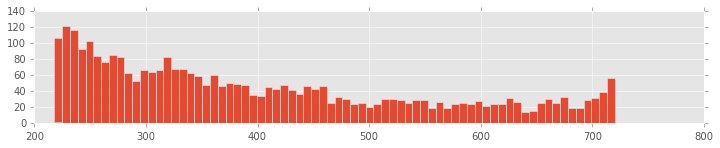

In [17]:
### DEFACTORING INSPECTION
plt.style.use('ggplot')
pd.Series([x[1] for x in wordcounts.most_common(n=3200)]).hist(bins=72, figsize=(12,2))

The plot above shows a histogram of the top 3,200 words and how they are expressed across corpus. The spike on the right end of this chart shows the 18 words that appear in all 720 documents (as we can see in the text table above). As a whole, most of the higher bars are on the left side of the chart indicating most of the words appear in fewer documents. In the course of data preparation it is important to inspect the shape of our data, in this case to visualize the distribution of our features. While it may not have a direct impact upon our analysis, it does provide a deeper perspective on the various transformations of our data. The chart above looks a lot different than the word frequency files of the poetry volumes at the start (or even of the original poems themselves). 

In [18]:
# vocablist = binormal_select(vocablist, positivecounts, negativecounts, totalposvols, totalnegvols, 3000)
# Feature selection is deprecated. There are cool things
# we could do with feature selection,
# but they'd improve accuracy by 1% at the cost of complicating our explanatory task.
# The tradeoff isn't worth it. Explanation is more important.
# So we just take the most common words (by number of documents containing them)
# in the whole corpus. Technically, I suppose, we could crossvalidate that as well,
# but *eyeroll*.

The author's code above does not actually perform any work as each line has been commented out, however we have decided to include it because it points towards an execution path and an interesting rationale for why it was not followed. In the "production" code the heuristic for feature selection is to simply to select the 3200 most common words by their appearance in the 720 documents. This is a simple and easy technique to implement and–more importantly–explain. Selecting the top words is a well established practice in text analysis and it has a high degree of methodologically face validity. It a good mechanism for removing features that have diminishing returns. However, the commented code above tells a different, and methodologically significant, story.

The comment discusses an alternative technique for feature selection using binormal selection, which he has implemented in the function `binormal_selection`. Because this function is commented out and not used in the analysis, we have opted to not include it as part of the defactoring. Instead, we have decided to focus on the more interesting  rationale about *why* `binormal_selection` is not being used in the analysis as indicated in the author's comments:

> There are cool things we could do with feature selection, but they'd improve accuracy by 1% at the cost of complicating our explanatory task.
> The tradeoff isn't worth it. Explanation is more important.

This comment reveals much about the reasoning, the effort, and energy focused on the important, but oft neglected in the humanities, work of discussing methodology. As Underwood argued in the *[Literary uses of high-dimensional space](http://journals.sagepub.com/doi/abs/10.1177/2053951715602494)* (2015) and repeatedly [on](https://tedunderwood.com/2013/06/11/on-not-trusting-people-who-promise-to-use-their-powers-for-good/) [his](https://tedunderwood.com/2015/12/02/emerging-conversations-between-literary-history-and-sociology/) [blog](https://tedunderwood.com/2016/05/04/versions-of-disciplinary-history/), while there is enourmous potential for the application of statistical methods in humanistic fields like literary history there is resistance to these methods because there is a resistance to *methodology*. Underwood has described the humanities disciplines relationship to methodology as an ["insistence on staging methodology as ethical struggle"](https://tedunderwood.com/2013/12/14/the-imaginary-conflicts-disciplines-create/). In this commented code we can see the meterial manifestation of Underwood's sentiment, in this case embodied by self-censorship in the decision to not use more statistically robust techniques for featues selection. We do not argue this choice compromises the analysis or final conclusions, rather we want to highlight the practical and material ways a resistance to diversity in research methods manifests in the digital humanities. By focusing on a close reading of the code, by *defactoring*, we provide a methodology to assist with the omnipresent *explanatory* task commensurate with the use of computational research methods in the humanities. 

In an algorithmic, data driven analysis, the selection of features is a *crucial* step because it effects the performance of the algorithm. In the digital humanities, feature selection is deeply inflected with the theory of the analysis and the context of the data. Claims made in and through this kind of analysis must attend to the representational configuration of the data. That is to say, we cannot take for granted how we have transformed data and what data are included or excluded from the analysis. Care, in the form of thorough documentation and thoughtful reflection, must be taken–especially at this unique moment as we are still learning how algorithmic, data-driven techniques can be leveraged to better understand our objects of study. 



#### Filtering Authors

In [19]:
donttrainon = list()

# Here we create a list of volumed IDs not to be used for training.
# For instance, we have supplemented the dataset with volumes that
# are in the Norton but that did not actually occur in random
# sampling. We want to make predictions for these, but never use
# them for training.

for idx1, anid in enumerate(orderedIDs):
    reviewedstatus = metadict[anid]['reviewed']
    date = infer_date(metadict[anid], datetype)
    if reviewedstatus == 'addedbecausecanon':
        donttrainon.append(idx1)
    elif date < pastthreshold or date > futurethreshold:
        donttrainon.append(idx1)

As the comments describe, this block of code creates a list of volume IDs not to be used in the training. What that means *in code* is that any volume with the metadata label `addedbecauseofcanon` or with a `date` outside of the thresholds defined by `pastthreshold` and `futurethreshold.` If we inspect the `donttrainon` variable we can see how many volumes satisfy these criteria.

In [20]:
### DEFACTORING INSPECTION
print("The variable donttrainon contains {} volume IDs".format(len(donttrainon)))

The variable donttrainon contains 0 volume IDs


It would appear there are no volumes to be filtered out by these criteria.

In [21]:
authormatches = [list(donttrainon) for x in range(len(orderedIDs))]
# For every index in authormatches, identify a set of indexes that have
# the same author. Obvs, there will always be at least one.

# Since we are going to use these indexes to exclude rows, we also add
# all the ids in donttrainon to every volume

for idx1, anid in enumerate(orderedIDs):
    thisauthor = metadict[anid]['author']
    for idx2, anotherid in enumerate(orderedIDs):
        otherauthor = metadict[anotherid]['author']
        if thisauthor == otherauthor and not idx2 in authormatches[idx1]:
            authormatches[idx1].append(idx2)

for alist in authormatches:
    alist.sort(reverse = True)

# I am reversing the order of indexes so that I can delete them from
# back to front, without changing indexes yet to be deleted.
# This will become important in the modelingprocess module.

This block of code is a bit more interesting than the last. Here the Underwood and Sellers group the volumes by the same author. The list `authormatches` is a list of lists for each volume. Each sub-list contains the IDS of all the volumes by the same author. Essentially this data structure represents the potential relations of each volume to other volumes, with that relation being "other volumes by the same author." This raises the question, how many volumes share the same author in this corpus?

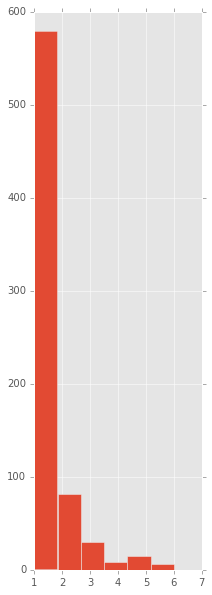

In [22]:
### DEFACTORING INSPECTION
pd.Series([len(x) for x in authormatches]).hist(bins=6,
                                                figsize=(3, 10))

This histogram tells us a majority of volumes are written by unique authors but that there are some authors who have written up to six volumes in the corpus. Note, we are generating this graph by counting the length of the list containing the volume IDs of other volumes by the same author. This means volumes written by the same author are counted twice. This isn't an issue for the purposes of our inspection, just that the sum total number of volumes represented by this histogram is greater than 720. 

#### Filtering Words

In [23]:
### DEFACTORING DEFINITIONS

usedate = False
# Leave this flag false unless you plan major
# surgery to reactivate the currently-deprecated
# option to use "date" as a predictive feature.

def get_features(wordcounts, wordlist):
    numwords = len(wordlist)
    wordvec = np.zeros(numwords)
    for idx, word in enumerate(wordlist):
        if word in wordcounts:
            wordvec[idx] = wordcounts[word]

    return wordvec

# In an earlier version of this script, we sometimes used
# "publication date" as a feature, to see what would happen.
# In the current version, we don't. Some of the functions
# and features remain, but they are deprecated. E.g.:

def get_features_with_date(wordcounts, wordlist, date, totalcount):
    numwords = len(wordlist)
    wordvec = np.zeros(numwords + 1)
    for idx, word in enumerate(wordlist):
        if word in wordcounts:
            wordvec[idx] = wordcounts[word]

    wordvec = wordvec / (totalcount + 0.0001)
    wordvec[numwords] = date
    return wordvec

This code cell defines two functions to be used below when opening and parsing the raw data files (in the `poems/` diretory). The function `get_features()` simply takes the wordcounts from the parsed volume and filters out any words that are not part of `wordlist`, which contains the list of word features that had been selected for this analysis. We have also included a second function, `get_features_with_date()`, even though it is not executed. This residual code points to yet another path not taken, one that uses the volume's publication date as a feature. As Underwood and Seller's comment indicates, this was an experiment from an "earlier version of this script...to see what would happen." 

In [24]:
volsizes = dict()
voldata = list()
classvector = list()

for volid, volpath in volspresent:

    with open(volpath, encoding = 'utf-8') as f:
        voldict = dict()
        totalcount = 0
        for line in f:
            fields = line.strip().split('\t')
            if len(fields) > 2 or len(fields) < 2:
                continue

            word = fields[0]
            count = int(fields[1])
            voldict[word] = count
            totalcount += count

    date = infer_date(metadict[volid], datetype)
    date = date - 1700
    if date < 0:
        date = 0

    if usedate:
        features = get_features_with_date(voldict, 
                                          vocablist, 
                                          date, 
                                          totalcount)
        voldata.append(features)
    else:
        features = get_features(voldict, vocablist)
        voldata.append(features / (totalcount + 0.001))


    volsizes[volid] = totalcount
    classflag = classdictionary[volid]
    classvector.append(classflag)
    
data = pd.DataFrame(voldata)

This is an important code block because we are now pulling the raw data files from teh `poems/` directory into memory, filtering out the unselected word features, and putting the data into a vectorized data structure. The code loops over the `volspresent` variable and parses each individual volume into the `voldict` dictionary. At this stage the code is reading in all of words, their frequencies, and tabulating the total number of words in that volume. Once all of the data for the volume has been read into memory, the code calls the `get_features` function that throws out the words not part of the selected word features stored in the `vocablist` variable. This is where the top 3200 words are foregrounded and the remaining, less commonly used words, are discarded. 

At this point, any prosaic resemblance left in the data is gone and now we are dealing entirely with textual data in a numeric form.

In [25]:
### DEFACTORING INSPECTION
print("The vector representation of {} by {}".format(metadict[volid]['title'], metadict[volid]['author']))
print("The vector has a length of {}.".format(len(features)))
print("The first 100 elements of the vector:")
print(features[0:100])

The vector representation of The croakers by Drake, Joseph Rodman,
The vector has a length of 3200.
The first 100 elements of the vector:
[  73.   87.  365.  297.   67.  464.  322.  143.  857.  110.   40.  751.
   86.  134.  106.   99.  141.   99.   63.  129.   73.   69.   48.   39.
   88.   46.   60.   35.   83.   40.   54.   62.   41.   31.   48.   26.
   90.   54.   18.   57.   48.   45.   34.   64.   15.   50.   28.   24.
   17.   76.   23.   33.   75.   30.   16.   30.   31.   17.   15.   32.
   10.   20.   22.   21.   21.   16.   18.   17.   24.    9.   10.    4.
   24.   10.   31.   15.   11.   61.    8.   25.   31.   10.    5.   12.
   31.   19.   21.   15.   13.   32.    6.   21.   19.   10.   36.   11.
   12.   17.   19.    5.]


The inspection above shows us the last volume processed by the loop, The croakers by Joseph Rodman Drake. As we can see, the words for this volume of poetry are now represended as a list of numbers (representing word frequencies). However, this list of numbers still requires additional transformation in order to be consumable by the Logistic Regression. The word frequencies need to be normalized so they are comparable across volumes. To do this Underwood and Sellers divide the frequency of each individual word (each number in the list above) by the total number of words in that volume (the `totalcount` variable. This makes volumes of different lengths comparable by turning absolute frequecies into relative frequencies. One thing we didn't quite understand at first is why the value of 0.001 has been added to the `totalcount` variable. When we asked, it turns out this is a ["lazy" way to prevent divide-by-zero errors](https://twitter.com/Ted_Underwood/status/826098272225918977).

The end result of the code we have executed thus far in the notebook is a very neat and tidy [DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) of numbers between zero and 1.

In [26]:
### DEFACTORING INSPECTION
data.tail()

,0,1,2,3,4,5,6,7,8,9,...,3190,3191,3192,3193,3194,3195,3196,3197,3198,3199
715,0.002785,0.003924,0.012594,0.012278,0.004050,0.017531,0.017024,0.007468,0.049048,0.003861,...,0.00000,0.000063,0.000000,0.000127,0.000000,0.000000,0.000063,0.000127,0.000000,0.000063
716,0.002720,0.004961,0.020723,0.011242,0.005241,0.020923,0.014722,0.010642,0.055889,0.008481,...,0.00004,0.000000,0.000000,0.000040,0.000000,0.000000,0.000040,0.000000,0.000000,0.000120
717,0.004339,0.005563,0.018757,0.014797,0.004984,0.025499,0.013662,0.011526,0.044256,0.004027,...,0.00000,0.000045,0.000067,0.000000,0.000022,0.000000,0.000067,0.000045,0.000045,0.000022
718,0.002397,0.004545,0.016135,0.012445,0.003252,0.020951,0.022660,0.005754,0.060580,0.007171,...,0.00000,0.000042,0.000104,0.000000,0.000063,0.000021,0.000021,0.000021,0.000021,0.000021
719,0.003667,0.004370,0.018334,0.014919,0.003365,0.023307,0.016174,0.007183,0.043048,0.005525,...,0.00000,0.000050,0.000000,0.000000,0.000050,0.000000,0.000000,0.000000,0.000000,0.000000


The last row in that table, 719, is the The croaker by Joseph Rodman Drake. It is just one of 720 relatively indistinguishable rows of numbers in this representation of 19th century poetry. This is a far cry from the original, prosaic representation literary historians are probably used to seeing:

![Screenshot of the Google Books site for The Croakers](notebook_resources/the-croakers.png)

In [27]:
sextuplets = list()
for i, volid in enumerate(orderedIDs):
    listtoexclude = authormatches[i]
    asixtuple = (data, 
                 classvector, 
                 listtoexclude, 
                 i, 
                 usedate, 
                 regularization)
    sextuplets.append(asixtuple)

This is the last step before we move away from the transformation of features and into the actual analysis of the data. This very simple bit of code gathers all of the relevant data and metadata necssary for performing the statistical analysis. The `sextuplets` variable is a list of 720 tuples containting six elements. Each item in the `sextuplets` list contains the necessary data structures to model each poem. The contents of each row of `sextuplets` is as follows:

- data: a normalized feature matrix. Word features are the columns and volumes are the rows. The dimensions are 720 x 3200
- classvector: the classification of documents as either 'reviewed' (1) or 'random' (0).
- listtoexclude: the list of poems to ignore because they are the same author
- i: the index of the volume
- usedate: a flag indicating if date is a feature. It is false in the default execution path.
- regularization: a parameter for the scikit-learn LogisticRegression function. hardcoded parameter from the beginning of the notebook.

With all of the data assembled and in the right shape, a process we call *data fitness*, we can now venture into the algorithmic territory and perform the statistical analysis. 

As we can see, the *fitted* representation of features has traveled a great distance from the original poetry. One of the most important aspects of *distant reading* is the work of cleaning, preparing, and normalizing texts to be "read" by an algorithm. When considering distance, we should think not only of the perspective that we, the analyst, are reading from, but also the distance traveled in terms of successive transformations and representations of the data. If computational literary history is a triathalon, we have only completed the first endurance test.

### Training Predictive Models

We are now about to dive into the very heart of the analysis, training predictive models on each volume. The code cells below do the following:


- Loop over every volume in the corpus. Within each loop:
    - Create a training set by removing the selected volume and other volumes by the same author from the corpus (performed by the `sliceframe()` function). This is the held out data.
    - Normalize the training set by computing the z-score for each feature/feature set (performed by the `normalizearray()` function).
    - Fit the model on the training data (performed by the `model_one_volume()` function).
    - Use the fitted model to predict the probability the (normalized) held out data was "reviewed" or "random."
    
What is important to understand is this section of the code doesn't train one model, it trains 720 independant models–one for each volume. As the code loops over the volumes, it holds out one volume, trains the model on all of the remaining volumes, and then uses that model to predict the status of the held out volume. Lather, Rinse, Repeat.

In [28]:
### DEFACTORING DEFINITION

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression


def sliceframe(dataframe, yvals, excludedrows, testrow):
    numrows = len(dataframe)
    newyvals = list(yvals)
    for i in excludedrows:
        del newyvals[i]
        # NB: This only works if we assume that excluded rows
        # has already been sorted in descending order !!!!!!!
        # otherwise indexes will slide around as you delete

    trainingset = dataframe.drop(dataframe.index[excludedrows])

    newyvals = np.array(newyvals)
    testset = dataframe.iloc[testrow]

    return trainingset, newyvals, testset

This function prepares the data for training a model by separating volumes using for training from a single volume to test the predictive power of the model. The function takes a dataframe containing the feature vectors, a list of the classifications for each volume, a list of volumes to exclude(because of shared authorship), and the the index of the specific volume to be held out. This function returns the dataframe with the hold out removed(`trainingset`), a list of classifications(`newyvals`) that maps to the modified dataframe, and the held-out volume that will be classified once the model has been trained(`testset`). 

In [29]:
def normalizearray(featurearray, usedate):
    '''Normalizes an array by centering on means and
    scaling by standard deviations. Also returns the
    means and standard deviations for features.
    '''

    numinstances, numfeatures = featurearray.shape
    means = list()
    stdevs = list()
    lastcolumn = numfeatures - 1
    for featureidx in range(numfeatures):

        thiscolumn = featurearray.iloc[ : , featureidx]
        thismean = np.mean(thiscolumn)

        thisstdev = np.std(thiscolumn)

        if (not usedate) or featureidx != lastcolumn:
            # If we're using date we don't normalize the last column.
            means.append(thismean)
            stdevs.append(thisstdev)
            featurearray.iloc[ : , featureidx] = \
                (thiscolumn - thismean) / thisstdev
        else:
            print('FLAG')
            means.append(thismean)
            thisstdev = 0.1
            stdevs.append(thisstdev)
            featurearray.iloc[ : , featureidx] = \
                (thiscolumn - thismean) / thisstdev
            # We set a small stdev for date.

    return featurearray, means, stdevs

This function *standardizes* the features by computing the z-score for the feature vectors. That is, it loops over each each column of the data, subtracts the column mean from each value, and then divides that value by the standard deviation. This is an important step in the data preparatin pipeline because it ensures all of the data values are on the same scale. For an extended discussion on features scaling, see [this blog post](http://sebastianraschka.com/Articles/2014_about_feature_scaling.html) by Sebastian Raschka who is the author of [Python Machine Learning](https://github.com/rasbt/python-machine-learning-book). 

In [30]:
def model_one_volume(data5tuple):
    data, classvector, listtoexclude, i, usedate, regularization = \
        data5tuple
    trainingset, yvals, testset = sliceframe(data, 
                                             classvector, 
                                             listtoexclude, 
                                             i)
    newmodel = LogisticRegression(C = regularization)
    trainingset, means, stdevs = normalizearray(trainingset, usedate)
    newmodel.fit(trainingset, yvals)

    testset = (testset - means) / stdevs
    prediction = newmodel.predict_proba(testset.reshape(1, -1))[0][1]
    if i % 50 == 0:
        print(i)
    # print(str(i) + "  -  " + str(len(listtoexclude)))
    return prediction

In many respects, this is the most important block of code in the entire document. The code above actually runs the logistic regression and does the magical, algorithmic work that generates a prediction about each individual volume. This function builds upon the two previous functions to assemble a normalized set of training data (`trainingset`) distinct from the single volume to be predicted (`testset`).

There are three lines of code involved in the computational modeling of the data. First, Underwood an Sellers instantiate a model object with the regularization parameter (more on that below):
```
newmodel = LogisticRegression(C = regularization)
```
Then they "fit" the model using the normalized trainting data:
```
newmodel.fit(trainingset, yvals)
```
Once a model has been "fit" to the data they can use that model to make predictions about unseen or held-out data. This is what they do with the `predict_proba()` function in this line:
```
prediction = newmodel.predict_proba(testset.reshape(1, -1))[0][1]
```

Those three lines are all it takes to do the computational part of of the analysis, the rest of the code up until this point has all been data preparation, cleaning, normalization, and re-shaping. This ratio of analytical to preperatory code is interesting and indicates claims that machines are taking our jobs are greatly exaggerated.

#### Regularization and Logistic Regression

The three lines of code above hide a significant amount of intellectual and computational work. The call to the `newmodel.fit()` function is a crucial step in the analytical process, but unfortunately far outside of the scope of effort we delinated for the current defactoring effort. Underwood and Sellers are using an implementation of Logistic Regression from the 3rd party Python library [`scikit-learn`](http://scikit-learn.org/stable/). Curious readers can look at the source code [here](https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/linear_model/logistic.py#L1138), but instead of diving into the code we are going to provide a non-mathy description of what is happening in that function call.

At a very high level, logistic regression is a machine learning algorithm for performing classification. Logistic regression works by estimating the parameters of a function, the *hypothesis representation*, that divides a multidimensional space into two parts (note, in this case we are talking about binomial or binary logistic regression, which classifies things into one of two bins). The hypothesis representation describes a line that winds its way through the space creating what is called the *decision boundary.* Every data point that lands on one side the boundary gets one label and every data point on the other side of the boundary gets the other label. Similar to linear regression, the goal is to find the best hypothesis representation, that is, the function that best draws a line dividing the space given the known data points. Once you have a good hypothesis representation, an appropriately *fit* model, you can begin to classify *new* data by dropping the into the multidimensional space and seeing on which side of the decision boundary they land.

The key to logistic regression is estimating the parameters of the hypothesis representation–the parameters to the function that draws a line through the multidimensional space. We can derive the parameters by using the *features* of existing data combined with their known labels; this is called *training data*. The modeling process, the function call to `newmodel.fit(trainingset, yvals)` in Underwood and Sellers's code, uses training data–the matrix of word features in the `data` variable and known labels ('reviewed' or 'random') in the `classvector` variable–to "learn" the parameters through a process called *gradient descent* (note: scikit-learn uses a different process called [*coordinate descent*](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) that is exceptionally complex). How gradient descent or the more advanced optimization functions like coordinate descent work are well beyond the scope of the discussion (and our explanatory power) so we will just nod and gesture towards the mathematical magic performed by the `newmodel.fit(trainingset, yvals)` function call.

For readers yearning for more, watch [Andrew Ng explain classification using Logistic Regression](https://class.coursera.org/ml-005/lecture) as part of his Coursera MOOC on machine learning.

##### Overfitting

One of the problems when fitting a logistic regression model is a tendency towards *overfitting*. Crudely this means the model, the function witht the learned parameters, that you estimated have tailored themselves such that they are overly optimized to the particular training data you provided. As such, the model becomes less useful for *prediction* or classifying new data because they are outside the fitness of the model. An overfit model is like a snug pear of jeans, once you put on a few pounds (add new data) they don't fit. In Underwood and Sellers's case, they are fitting models on all volumes *except one*, which is *held out.* Then they test the predictive performance of the model by seeing if it correctly classifies the held-out volume. If they *overfit* the models, the model will to a terrible job guessing the status of the held out volumes. 

When Underwood and Sellers instantiated the model (`newmodel = LogisticRegression(C = regularization)`), the set a regularization parameter on the model. Regularization is a technique for logistic regression (and other machine learning algorithms) that smooths out the tendency toward overfitting with some more mathematical gymnastics that we don't quite have the power to explain with words, but can explain visually. The diagram below shows how regularization can help with the fitness of the model:

![Regularization](notebook_resources/regression_figures.png)

*On the left side is a linear regression which doesn't quite fit the data. In the middle is an overfit logistic regression. On right side is a regularized logistic regression.*

As the diagrams show, the regularized logistic expression (the right side) does have a bit of error, there are pink and blue dots on the wrong sides of the decision boundary, but as more data get added it will generally be more right than the overfitted model as represented by the middle diagram (the squiggly decision boundary). 

In the grand scheme of things, logistic regression isn't actually that complicated of a supervised learning algorithm (compared to algorithms like [support vector machines](https://en.wikipedia.org/wiki/Support_vector_machine) or [deep learning](https://en.wikipedia.org/wiki/Deep_learning)). Logistic regression has the advantage of being powerful, theoretically grounded (in the statistical sense), and easy to understand how it makes assertions (unlike deep learning). This relative simplicity is exceptually important because when we make computationally inflected claims in the digital humanities, we need to be able to *explain* them and understand just *how* such assertions are derived. We cannot permit "black box" computational scholarship.

#### Running the Regression

In [31]:
# Now do leave-one-out predictions.
print('Beginning multiprocessing.')

pool = Pool(processes = 4)
res = pool.map_async(model_one_volume, sextuplets)

# After all files are processed, write metadata, errorlog, and counts of phrases.
res.wait()
resultlist = res.get()

assert len(resultlist) == len(orderedIDs)

logisticpredictions = dict()
for i, volid in enumerate(orderedIDs):
    logisticpredictions[volid] = resultlist[i]

pool.close()
pool.join()

print('Multiprocessing concluded.')

Beginning multiprocessing.
0
50
100
150
200
250
300
350
450
500
400
550
600
650
700
Multiprocessing concluded.


Now that we have describe the code that does the actual computational modeling, we need to work our way through the scaffolding that automates the training each individual models for all 720 volumes. Training or fitting a logistic regression model takes time (the computer has to do some hard work) and training 720 different models takes 720 times longer! Fortunately, this is an [embarrassingly parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel) computational task and so we can train the models using parallel processing instead of one after the other. Using Python's built in parallel processing modules, this code can speed up the process. Still, this block of code takes a fair amount of time to execute, around twenty minutes on a quad core MacBook Pro. 



In [32]:
### DEFACTORING INSPECTION
print("There are {} predictions.".format(len(logisticpredictions)))


There are 720 predictions.


What emerges from the other side of this computationally intensive task are a series of predictions, 720 to be specific, for each of the modeled volumes. These predictions, stored in the `logisticpredictions` variable, are the algorithm's assertions of each volumes reviewed status. Additionally, because we already know the status of the modeled volumes we can compare the performance of the predictive model to the "[ground truth](https://en.wikipedia.org/wiki/Ground_truth)" and see if the algorithm was able to detect patterns. 

In [33]:
truepositives = 0
truenegatives = 0
falsepositives = 0
falsenegatives = 0
allvolumes = list()

with open(outputpath, mode = 'w', encoding = 'utf-8') as f:
    writer = csv.writer(f)
    header = ['volid', 
              'reviewed', 
              'obscure', 
              'pubdate', 
              'birthdate', 
              'gender', 
              'nation', 
              'allwords', 
              'logistic', 
              'author', 
              'title', 
              'pubname', 
              'actually', 
              'realclass']
    writer.writerow(header)
    for volid in IDsToUse:
        metadata = metadict[volid]
        reviewed = metadata['reviewed']
        obscure = metadata['obscure']
        pubdate = infer_date(metadata, datetype)
        birthdate = metadata['birthdate']
        gender = metadata['gender']
        nation = metadata['nation']
        author = metadata['author']
        title = metadata['title']
        canonicity = metadata['canonicity']
        pubname = metadata['pubname']
        allwords = volsizes[volid]
        logistic = logisticpredictions[volid]
        realclass = classdictionary[volid]
        outrow = [volid, 
                  reviewed, 
                  obscure, 
                  pubdate,
                  birthdate, 
                  gender, 
                  nation, 
                  allwords, 
                  logistic, 
                  author, 
                  title, 
                  pubname, 
                  canonicity, 
                  realclass]
        writer.writerow(outrow)
        allvolumes.append(outrow)

        if logistic > 0.5 and classdictionary[volid] > 0.5:
            truepositives += 1
        elif logistic <= 0.5 and classdictionary[volid] < 0.5:
            truenegatives += 1
        elif logistic <= 0.5 and classdictionary[volid] > 0.5:
            falsenegatives += 1
        elif logistic > 0.5 and classdictionary[volid] < 0.5:
            falsepositives += 1

This code is a bit simpler than its predecessors. This block writes a CSV file to disk containing 720 rows of volume metadata, the predicted classification, and the actual classification.  

### Modeling Coefficients


The code below represents a shift in the focal object of the analysis. In the previous section 720 distinct logistic regressions were trained in order to predict the classification of a single, held-out poem. This is the data that was used to produce the main figure, *Figure 1. Predicted probabilities that volumes come from the reviewed set.* 

The code below generates a single logistic regression model, trained on *all of the data* with nothing held-out. This model has no held-out data because it is not being used for predictive purposes. Instead, the properties of this model, the parameters of the *hypothesis representation*, are interrogated to better understand the influence of individual features, words, on reviewed vs. unreviewed volumes. This isn't using computational modeling to *predict* a phenomena, it is using the computational model to *explore* and *explain* patterns and features of the phenomena.

In [34]:
donttrainon.sort(reverse = True)
trainingset, yvals, testset = sliceframe(data, 
                                         classvector, 
                                         donttrainon, 
                                         0)
newmodel = LogisticRegression(C = regularization)
trainingset, means, stdevs = normalizearray(trainingset, usedate)
newmodel.fit(trainingset, yvals)

coefficients = newmodel.coef_[0] * 100

coefficientuples = list(zip(coefficients, 
                            (coefficients / np.array(stdevs)), 
                            vocablist + ['pub.date']))
coefficientuples.sort()
if verbose:
    for coefficient, normalizedcoef, word in coefficientuples:
        print(word + " :  " + str(coefficient))

print()
accuracy = (truepositives + truenegatives) / len(IDsToUse)

This code functions much like the code in the `model_one_volume()` function except it only trains a single model for the purposes of investigating the model parameters, the coefficients, to better understand how particular word features affect the model. Looking at the code, specifically the call to `sliceframe()` reveals this model actually does have some hold-out data, the first volume at index zero. We suspect the cost of excluding a single volume is less than the effort of re-implementing the `sliceframe()` function. The code to instantiate and train the model is identical to the code above, but instead of predicting the status of the held-out data the code extracts the coefficients from the model and puts them in the `coefficients` variable. 

In [35]:
### DEFACTORING INSPECTION
print("There are {} coefficients in this model.".format(len(coefficientuples)))

There are 3200 coefficients in this model.


In [36]:
### DEFACTORING INSPECTION
print("First ten items in the list of coefficients.")
coefficientuples[:10]

First ten items in the list of coefficients.


[(-0.45180546828790275, -1531.7569546400514, "i'll"),
 (-0.42717704510819149, -7255.8869103842935, 'mission'),
 (-0.41159102355540844, -862.50368642685294, 'tis'),
 (-0.37941129693254255, -1125.2320863193811, 'oft'),
 (-0.37837845957642408, -3337.9092000188139, 'greet'),
 (-0.37400199665483852, -2558.9928556667601, 'wondrous'),
 (-0.37128131731420894, -222.89616295007758, 'our'),
 (-0.36953210740223846, -4356.5701405021873, 'anxious'),
 (-0.35915574449123455, -2087.7419279917326, 'cheer'),
 (-0.35635118303154967, -1383.5403805193118, "we'll")]

In [37]:
### DEFACTORING INSPECTION
print("Last ten items in the list of coefficients.")
coefficientuples[-10:]

Last ten items in the list of coefficients.


[(0.37283651125232864, 4801.8185708133651, 'brows'),
 (0.38130629612831068, 224.49681561500518, 'not'),
 (0.38253640523020777, 1149.1448557531303, 'half'),
 (0.38450626018051548, 398.90786329693742, 'what'),
 (0.38472474120396344, 6977.7066166545164, 'whereon'),
 (0.39934114418248107, 3172.5654375312929, 'sake'),
 (0.40303202262304672, 2023.211854947454, 'slow'),
 (0.40679871689085145, 3934.404837702974, 'hollow'),
 (0.41263534305491301, 1531.9890844133365, 'black'),
 (0.452532248863738, 615.03358571724243, 'eyes')]

At a practical level, the coefficients are a list of numbers, one per word feature, that determine the shape of the line through the multidimensional space. These results tell us the influence of particular words in the classification of volumes in the corpus. Looking at the normalized values helps us understand the degree to which particular words are more or less associated with reviewed or unrevied poetry. 

In [38]:
coefficientpath = outputpath.replace('.csv', '.coefs.csv')
with open(coefficientpath, mode = 'w', encoding = 'utf-8') as f:
    writer = csv.writer(f)
    for triple in coefficientuples:
        coef, normalizedcoef, word = triple
        writer.writerow([word, coef, normalizedcoef])


### DEFACTORING NAMESPACE
rawaccuracy = accuracy 

This code generates the `mainmodelcoefficients.csv` output file, which contains the word, its coefficient and its normalized coefficients.

### Plotting Results

The final function of the analysis is to test the accuracy of the model(s). This code produces a plot giving a sense of how the model performed compared to the known classifications.

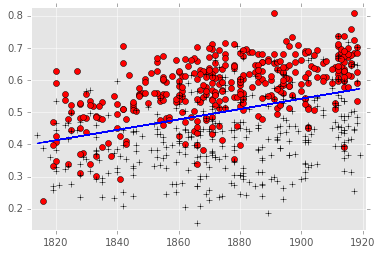

If we divide the dataset with a horizontal line at 0.5, accuracy is:  0.7763888888888889
Divided with a line fit to the data trend, it's  0.791666666667


In [39]:
### DEFACTORING FUNCTION PARAMETERS
modeltype = 'linear'
datelimits = []
''' Takes a set of predictions produced by a model that knows nothing about date,
and divides it along a line with a diachronic tilt. We need to do this in a way
that doesn't violate crossvalidation. I.e., we shouldn't "know" anything
that the model didn't know. We tried a couple of different ways to do this, but
the simplest and actually most reliable is to divide the whole dataset along a
linear central trend line for the data!
'''



listofrows = list()
classvector = list()

# DEPRECATED
# if modeltype == 'logistic' and len(datelimits) == 2:
#     # In this case we construct a subset of data to model on.
#     tomodeldata = list()
#     tomodelclasses = list()
#     pastthreshold, futurethreshold = datelimits

for volume in allvolumes:
    date = volume[3]
    logistic = volume[8]
    realclass = volume[13]
    listofrows.append([logistic, date])
    classvector.append(realclass)

    # DEPRECATED
    # if modeltype == 'logistic' and len(datelimits) == 2:
    #     if date >= pastthreshold and date <= futurethreshold:
    #         tomodeldata.append([logistic, date])
    #         tomodelclasses.append(realclass)

y, x = [a for a in zip(*listofrows)]
plt.axis([min(x) - 2, max(x) + 2, min(y) - 0.02, max(y) + 0.02])
reviewedx = list()
reviewedy = list()
randomx = list()
randomy = list()

for idx, reviewcode in enumerate(classvector):
    if reviewcode == 1:
        reviewedx.append(x[idx])
        reviewedy.append(y[idx])
    else:
        randomx.append(x[idx])
        randomy.append(y[idx])

plt.plot(reviewedx, reviewedy, 'ro')
plt.plot(randomx, randomy, 'k+')

if modeltype == 'logistic':
    # all this is DEPRECATED
    print("Hey, you're attempting to use the logistic-tilt option")
    print("that we deactivated. Go in and uncomment the code.")

    # if len(datelimits) == 2:
    #     data = pd.DataFrame(tomodeldata)
    #     responsevariable = tomodelclasses
    # else:
    #     data = pd.DataFrame(listofrows)
    #     responsevariable = classvector

    # newmodel = LogisticRegression(C = 100000)
    # newmodel.fit(data, responsevariable)
    # coefficients = newmodel.coef_[0]

    # intercept = newmodel.intercept_[0] / (-coefficients[0])
    # slope = coefficients[1] / (-coefficients[0])

    # p = np.poly1d([slope, intercept])

elif modeltype == 'linear':
    # what we actually do

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    slope = z[0]
    intercept = z[1]

plt.plot(x,p(x),"b-")
plt.show(block = False)

x = np.array(x, dtype='float64')
y = np.array(y, dtype='float64')
classvector = np.array(classvector)
dividingline = intercept + (x * slope)
predicted_as_reviewed = (y > dividingline)
really_reviewed = (classvector == 1)

accuracy = sum(predicted_as_reviewed == really_reviewed) / len(classvector)

### DEFACTORING NAMESPACE
tiltaccuracy = accuracy 

print('If we divide the dataset with a horizontal line at 0.5, accuracy is: ', 
      str(rawaccuracy))

print("Divided with a line fit to the data trend, it's ", 
      str(tiltaccuracy))

The code above generates a best fit line, using [numpy.polyfit](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.polyfit.html), for all of the results. Underwood and Sellers then calculate the predicted-as-reviewed, which are volumes falling above the dividing line. The accuracy of the dividing line is computed by the total number of predicted-as-reviewed that were actually reviewed divided by the total. Note, this is the accuracy of the dividing line, not the accuracy of the model(s) to predict the reviewed stats of the poems.

## Conclusions

This notebook contains all of the code necessary to run through a full execution of the computational analysis.

### Musings

#### Affordances of the Jupyter Platform 

We should more fully unpack the implications of the Jupyter *platform* and what it means to *read* the code. As we mentioned briefly above, the Jupyter platform allows us to interrogate the code and, more importantly, the execution environment described by the code (TODO: find some theory to talk about the relationship between the code and the computation, Ramsay? [Kittler](https://en.wikipedia.org/wiki/Friedrich_Kittler), there must be something in [critical code studies](https://en.wikipedia.org/wiki/Critical_code_studies) that unpacks this) in a performance of *reading* that is theoretically interesting. What we have is an act of reading at the intersection of Underwood and Seller's code, ourselves as critical interpreters, but also the computer as an interpreter (albiet not critical, but what kind of interpreter? *relentlessly literal*). This intersection is made possible by the Jupyter platform because we can work our way through the code, that is, step through it, at our own pace, creating critically meaningful blocks of Underwood and Seller's undifferentiated scripts. The Jupyter platform allows us to incrementally execute these blocks and inspect the state of the execution environment the code instantiates/describes. In this sense we are simultaneously reading the code as a text and as a set of instructions. We can *read into* the code and the computataional work behind the code to achieve a much greater depth. In some sense we can ***test*** our own assumptions about what the code does by actually doing it (TODO: is this there the Berry's *coping tests* come into play?). The moments when we do a *DEFACTOR INSPECTION* and create new code cells with own own code we are simultaneously doing an act of writing and reading. We are writing a *coping test* in order to read the state of the execution environment and *test* our understanding of that state which we we can interpret from our reading of the code, but can also *directly observe with our own code*. 

What kind of reading is this, it isn't distant reading. It is more akin to *close reading*, but I am not sure the close reading accounts for the interactivity and the inspection work that occurs in our proposed method. Defactoring is a method of reading complex objects and environments, a way of reading the code and the model of reality it instantiates. In making such a claim it is vitally important to understand the material circumstances that make this possible, that is to understand that the Jupyter *platform* is intimately wrapped up in the methodological construct. Defactoring cannot be pure theoretical method, it has to be practically grounded, we might say, *codified* in a technical platform. This isn't such an outrageous thing to say as book historians have been pointing out the material conditions of the monograph and its relationship to knowledge for ages (CITATION-NEEDED).

This insight is nothing new to platform or code studies people who have spilled a shoal of ink discussing and debating this point. However, what has been lacking are efforts to *embody* these insights in an interrogation of code, computations, algorithms, and data. We have gone beyond simply pointing out the material conditions of code and *done something with it*. Queue the theory vs. practice divide, but we argue for the construction of bridges and the crossing back and forth precisely because it allows us an avenue towards deeper insight into the production of data and computationally inflected knowledge–such as the work of Underwood and Sellers in Pace of Change. 

We argue the attributes of data-driven, computational, and algorithmic scholarship such as Pace of Change warrants a different kind of peer review, a form of review that dives into the code (we'd also argue it warrants a different kind of publishing, but we can only address one issue at a time ;). Given the fact the data and the code are just as important as charts and the write-up that are currently the currency of scholarly publishing and communication. 


#### Software Layers

[This blog post by Konrad Hinsen](http://blog.khinsen.net/posts/2017/01/13/sustainable-software-and-reproducible-research-dealing-with-software-collapse/) talks about the sustainability and reproducibility of scientific software, I think many of the points are relevant here. Specific he talks about *software collapse*, which is the foundations of scientific software become unstable and the code/softare used in a discovery ceases to function. He prefers the *collapse* metaphor to the more common *rot* metaphoe because if emphasises the fact the software hasn't change but the context surrounding that software, the foundations, have changed.

Another interestion point from the post are the four layers of scientific software. These are useful for us with respect to Defactoring because it helps illuminate the specific kind of software/code we are looking to focus our attention upon. In Hinsen's model there are four layers of scientific software:

1. Non-scientific, or generalized computational infrastructure like operating systems, compilers, and user interfaces. In `paceofchange` this would be the Docker container and Python runtimes (and everything underneath them) that make up the environment.
2. Scientific computational infrastructure, which includes the generalized  libraries implementing particular algorithms or data structures commonly used across scientific settings. For us, this includes the 3rd party libraries like the Logistic Regession implementation from `scikit-learn.`
3. Hinsen posits there is a third layer of disciplin-specific research software that are similar to those in layer two, but specialized for a specific disciplinary community. There isn't an example with this specific project, but Matt Jocker's [syuzhet](https://github.com/mjockers/syuzhet) package for R would be a good example for literary analysis.
4. The fourth layer is project specific code developed in pursuit of the very specific set of tasks associated with a particular analysis. This code often includes plumbing code that connects the other layers to accomplish a desired outcome, such as performing a logistic regression to create a predictive model of reviewed and unreviewed poetry volumes. The code that we have described in this notebook would be an example of this kind of project specific software.

The model of different software layers helps explain the kinds of code most suitable for Defactoring, the fourth player–project specific code. As Hinson points out, layer four software is the least likely to be shared or preserved because it is bespoke code intended only for a specific use case. What we hope to achieve is the creation of ag mechnism that would make this code integral to the publication process and thus make publishing forth layer code a requirement for computational and data intensive research. While it is wonderful to share this code, there needs to be stronger incentives to distribute this kind of code, so argue layer four code needs to be peer-reviewed alongside the narrative that uses it. Defactoring provides a method for reviewing this kind of code and contribute to the editorial aspect of formal scholarly publishing pipelines.


#### Publishing

* [A blog post on preparing a notebook for publication](http://blog.juliusschulz.de/blog/ultimate-ipython-notebook)